# Homework 12 Assignment 1: TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


In [1]:
#using ADS kernel

In [2]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd
import os

from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import statsmodels.api as sm

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20


Populating the interactive namespace from numpy and matplotlib


In [3]:
#environmental variable
#create the env variable since previous doesn't work
os.environ["PUIDATA"] = "%s/PUI2018/PUIdata"%os.getenv("HOME")

print("PUIdata", os.getenv("PUIDATA"))

PUIdata /nfshome/sjf374/PUI2018/PUIdata


In [4]:
!curl -O https://raw.githubusercontent.com/fedhere/PUI2018_fb55/master/HW11_fb55/Ridetypes.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12802  100 12802    0     0  78584      0 --:--:-- --:--:-- --:--:-- 79024


In [5]:
ridefile = os.getenv("PUIDATA") + "/Ridetypes.png"

In [6]:
os.system("mv Ridetypes.png " + ridefile)

0

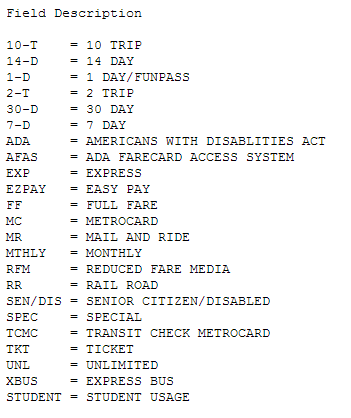

In [7]:
Image(filename = ridefile)

# read in data as instructed above

In [8]:
#!curl -O https://github.com/fedhere/PUI2018_fb55/raw/master/HW11_fb55/MTA_Fare_py3.npy

In [9]:
#mtafile = os.getenv("PUIDATA") + "/MTA_Fare_py3.npy"

In [10]:
#os.system("mv MTA_Fare_py3.npy " + mtafile)

In [11]:
#np.load(os.getenv("PUIDATA") + "/MTA_Fare_py3.npy")
#still getting a pickle error

In [12]:
mta = np.load("MTA_Fare_py3.npy")

In [13]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [14]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])
print("number of ride types", len(ridetype))

number of ride types 23


In [15]:
dates = pd.date_range(start= '5/19/2010', periods=194, freq='7D')

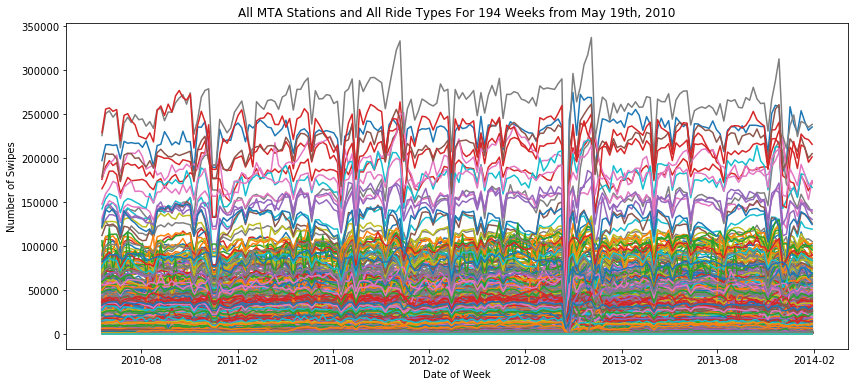

In [16]:
# plot the data in natural space
# then plot the  data in log space 
#(may take a while to plot because of the very inefficient double for loop - 
# the counter needs to get to 23)

pl.figure(figsize(14,6))

for station in range(len(mta)):
    for ridetype in range(len(mta[station])):
        plt.plot(dates, mta[station,ridetype])


pl.xlabel('Date of Week')
pl.ylabel('Number of Swipes')
pl.title('All MTA Stations and All Ride Types For 194 Weeks from May 19th, 2010')

#### Plot 1: count of mta swipes per week per ride type. This is pretty messy. It will be best replotting with a cleaner version. It seems that there is something significant between 2011-08 and 2013-02.

In terms of periodicity it's hard to see if 

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  
/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


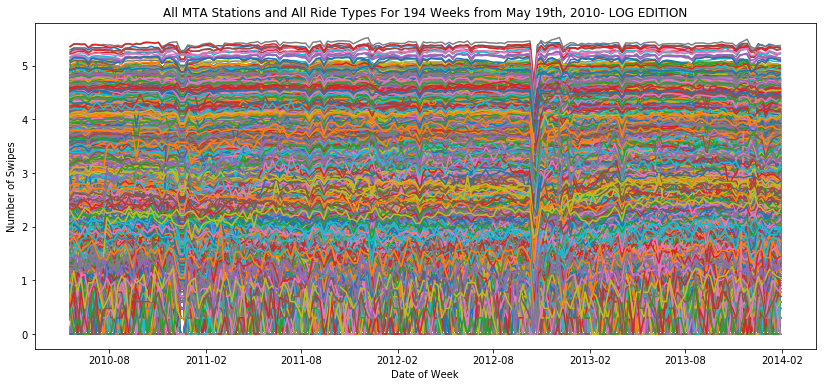

In [17]:
#computational extensive
pl.figure(figsize(14,6))

for station in range(len(mta)):
    for ridetype in range(len(mta[station])):
        plt.plot(dates, np.log10(mta[station,ridetype]))


pl.xlabel('Date of Week')
pl.ylabel('Number of Swipes')
pl.title('All MTA Stations and All Ride Types For 194 Weeks from May 19th, 2010- LOG EDITION')

#### Figure 2: time series for all ride types and all stations in semi-log space. The event as seen before, looks more prominent.  

# 4. Fourier transform
from the numpy package you will nees only the 
np.fft.rfft() to take the fourier transform

and

np.fft.rfftfreq() to create a meaningful x axis 

In [18]:
# flatten to sum of all rides for each station

In [19]:
# utilized UI notebook lab
# https://github.com/fedhere/UInotebooks/blob/master/timeseries/fourier.ipynb

In [20]:
#as seen in homework from last week

In [21]:
mta_clean = mta.astype(float) # to correct for error with nans

In [22]:
mta_clean[mta_clean == -1] = np.nan

In [23]:
## flatten the dataframe to sum over the wipes per station per week
mta_sum_by_station = np.nansum(mta_clean, axis = 1)
mta_sum_by_station.shape

(600, 194)

In [24]:
# periodicity of 3 years- narrows down the data, 
# but documentation suggests that can help
weeks = 3*52

In [25]:
weeks

156

In [26]:
f = np.abs(np.fft.rfft(mta_sum_by_station, n=weeks))**2

In [27]:
f.shape

(600, 79)

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


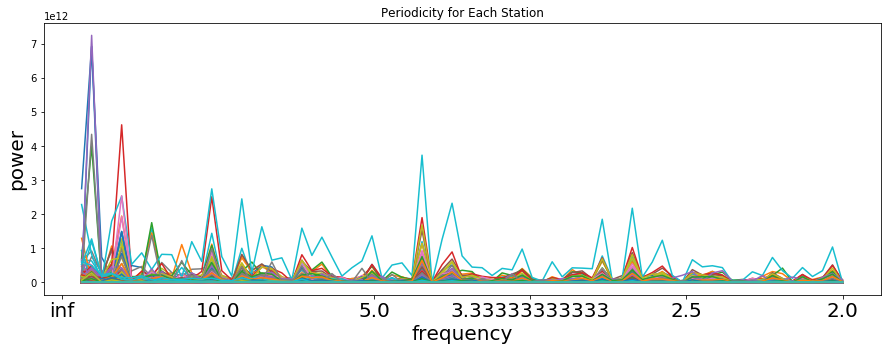

In [28]:
fig = pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
for station in range(len(mta_sum_by_station)):
    f = np.abs(np.fft.rfft(mta_sum_by_station[station], n=weeks))**2
    ax.plot(np.fft.rfftfreq(weeks, 1.0)[2:], (f[2:]), '-')
    ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
    pl.ylabel("power", fontsize=20)
    pl.xlabel("frequency", fontsize=20)
pl.title('Periodicity for Each Station')

#### Figure 3: Difficult to gather any information from this graph. The turqouise station seems to have more power of periodicity

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


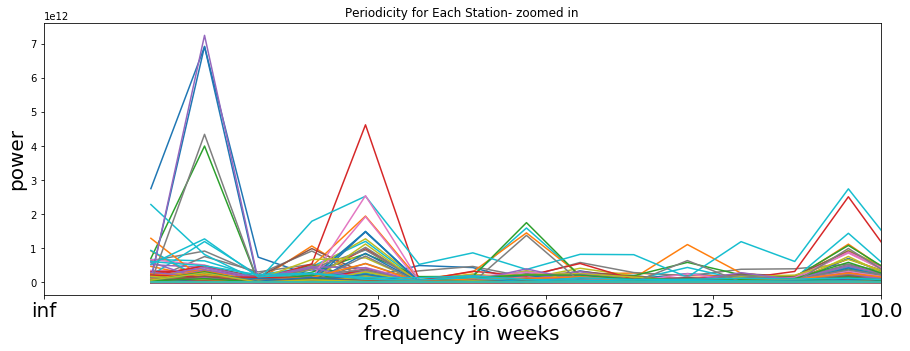

In [29]:
fig = pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
for station in range(len(mta_sum_by_station)):
    f = np.abs(np.fft.rfft(mta_sum_by_station[station], n=weeks))**2
    ax.set_xlim(0,.1) 
    ax.plot(np.fft.rfftfreq(weeks, 1.0)[2:], (f[2:]), '-')
    ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
    pl.ylabel("power", fontsize=20)
    pl.xlabel("frequency in weeks", fontsize=20)
pl.title('Periodicity for Each Station- zoomed in')

Figure 4: Not surprisingly that there is high periodicty around 52 weeks. Also see some periodicity every helf year at 26 weeks. 

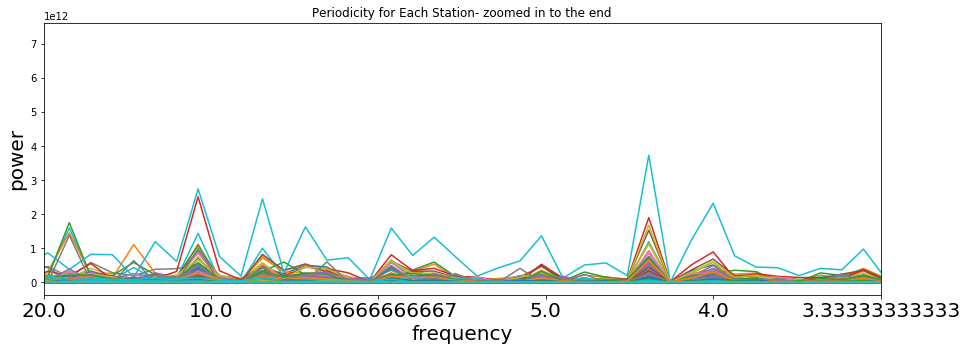

In [30]:
fig = pl.figure(figsize=(15,5))
ax=fig.add_subplot(111)
for station in range(len(mta_sum_by_station)):
    f = np.abs(np.fft.rfft(mta_sum_by_station[station], n=weeks))**2
    ax.set_xlim(.05,.3) 
    ax.plot(np.fft.rfftfreq(weeks, 1.0)[2:], (f[2:]), '-')
    ax.set_xticklabels([ "%s"%(1/f) for f in ax.get_xticks()], fontsize=20)
    pl.ylabel("power", fontsize=20)
    pl.xlabel("frequency", fontsize=20)
pl.title('Periodicity for Each Station- zoomed in to the end')

Figure 5: once again turqouise seems to have the highest periodicity across the board but the red station also has one around 12 weeks. 

In [32]:
# initially rotated through, but now I want one object with the entire
# database 
f_all = np.abs(np.fft.rfft(mta_sum_by_station, n=weeks))**2

In [33]:
f_all.shape
# good that there are 600 stations still
# the way this function calculates, 
# it only looks at opporunities for periodicty, periods that occur more than once

(600, 79)

In [34]:
f_all

array([[  3.80666127e+14,   3.45953289e+12,   2.75637898e+12, ...,
          5.26964623e+09,   2.20632964e+10,   6.51491122e+09],
       [  1.60682967e+13,   2.40915413e+12,   4.72082174e+11, ...,
          1.60847630e+09,   1.69642258e+09,   3.05786880e+09],
       [  1.22979228e+12,   1.20363250e+09,   9.41016342e+08, ...,
          7.58084368e+07,   1.65053999e+08,   4.09600000e+03],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [35]:
argmax(f_all)

13351

In [36]:
#top stations across each column, you can see that 0 , 32, 169 occur  often. 

In [37]:
top_by_col = argmax(f_all, axis=0)

In [38]:
top_by_col

array([169,   0,   0, 194,   0, 169,  83, 169, 169,  32, 169, 169,  21,
       169, 169, 169, 169, 169, 169,  32, 169, 169, 169,  17, 169, 169,
       169, 169, 169, 169, 169, 169, 234, 169, 169, 169, 169,  17, 169,
       169, 169, 169, 169, 169, 169, 169, 169, 169, 327, 169, 169, 169,
       169, 169, 169, 194,  45, 169,  10, 169, 169, 169, 194, 169, 169,
       169, 169,  19,  32, 169, 194, 169,  32, 194, 169, 169, 169, 169,  21])

In [39]:
#https://stackoverflow.com/questions/10741346/numpy-most-efficient-frequency-counts-for-unique-values-in-an-array
#which stations have the highest value in each column and counts that they "win"
unique, counts = np.unique(top_by_col, return_counts=True)

print (np.asarray((unique, counts)).T)

[[  0   3]
 [ 10   1]
 [ 17   2]
 [ 19   1]
 [ 21   2]
 [ 32   4]
 [ 45   1]
 [ 83   1]
 [169  57]
 [194   5]
 [234   1]
 [327   1]]


In [40]:
#169 is confirmed again with the following method:

In [41]:
np.unravel_index(argmax(f_all), (600, 79))

(169, 0)

In [42]:
#sort the array and replace content with rank https://stackoverflow.com/questions/27473601/next-argmax-values-in-python
#one more method to see if this is correct. 

In [43]:
find = np.argsort(-f_all[:,0])
#0 as that is the column consistently with the highest scores across all rows. 

In [44]:
find[:4]

array([169,  21,  32,  45])

In [45]:
#changes a bit with each method, but 169 is at the top of all

In [46]:
top_lst = [169, 194, 32, 0]

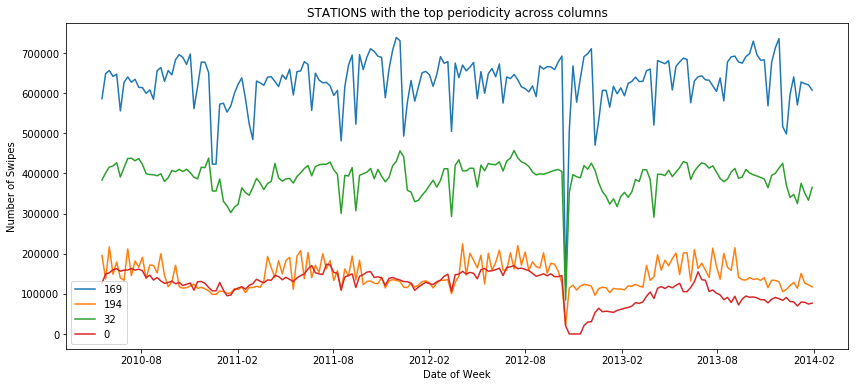

In [47]:
pl.figure(figsize(14,6))

for station in top_lst:
    plt.plot(dates, mta_sum_by_station[station], label=str(station))


pl.xlabel('Date of Week')
pl.ylabel('Number of Swipes')
pl.legend()
pl.title('STATIONS with the top periodicity across columns')

Figure 6: all of these stations seem to have very clear valleys at consistent places. This of course is excluding the hurricane sandy day.  